<b>This script requires astropy 3.0dev</b>

<h2>Fitting compound models using data normalization</h2>

In these experiments, we run the astropy fitters with the model components initialized to their default values provided by astropy, not to the data at hand as is currently done in specviz.

This is done using Thomas Robitaille's suggestion of using the units machinery in astropy to perform the fit on normalized data. In this way, all fitters will see a data set that exists in the range [-1:1] in both X and Y coordinates.

For comparison purposes, we also run the same fitters on the same data sets, using specviz's method of initialization based on the actual data. 

<b>Result: </b> these experiments confirm what we have found before, that of the three fitters offered in astropy.modeling, L-M seems to be the most reliable in general. 

The experiments suggest that the normalization technique is a viable alternative to providing initial guesses based on the actual data at hand. However, this can be said for now only for simple cases as the one tested here, where one component dominates the model. In more complex models with many spectral components, this approach of  normalizing the data to [-1:1] remains to be tested yet.

These results also tell that the SLSQP method in practice requires the data to be normalized to the [-1:1] interval. L-M was better behaved in that situation, but also works more or less, when using initial guesses instead. Simplex seems to be the other way around, behaving better when provided with initial guesses.

<b>Caveat: </b> this method cannot be implemented in specviz right now, since it depends on astropy v3.0 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.gcf().set_size_inches(8.,4.)

from astropy import units as u
from astropy.modeling import models, fitting


# This is basically Thomas Robitaille's example 
# normalization/fitting code, cast in the form 
# of a function.
    
def perform_fit(fitter, model, wave, flux, normalize):

    if not normalize:
        return fitter(model, wave, flux, maxiter=5000)    
    
    # Define custom units for x and y
    ux1 = u.def_unit('ux1')
    uy1 = u.def_unit('uy1')
    w1 = wave * ux1
    f1 = flux * uy1

    # Determine maximum values in each direction
    wmax = np.max(np.abs(w1.value))
    fmax = np.max(np.abs(f1.value))

    # Define new units so that in this system, the data is always in the range
    # [-1:1] in both directions and convert data to that frame.
    ux2 = u.Unit(wmax * w1.unit)
    uy2 = u.Unit(fmax * f1.unit)
    w2 = w1.to(ux2)
    f2 = f1.to(uy2)

    # Strip away the units for the fitting
    w3 = w2.value
    f3 = f2.value

    # Run the fitting
    m3 = fitter(model, w3, f3, maxiter=5000)

    if 'message' in fitter.fit_info:
        print(fitter.fit_info['message'])

    # Add units to the parameters for the data that was fit, and then transform
    # the parameters to the original units of the data
    m2 = m3.with_units_from_data(x=w2, y=f2)
    m1 = m2.without_units_for_data(x=w1, y=f1)

    return m1

In [2]:
# Run one test: for a given fitter and model, fit two data sets. 
# Do the fit a number of times with different realizations of the 
# noise, so as to probe the fitter's sensitivity to noise.

def test(fitter, model, w, f1, f2, scale, normalize, title):
    result_1 = []
    result_2 = []
    
    # run the fitter six times, each time with a 
    # different noise realization.
    colors = ['-g','-c','-b','-y','-m','-r']
    
    for k in range(len(colors)):
        f1_n = f1 + scale / 10 * np.random.normal(0, 1, len(wave))
        f2_n = f2 + scale / 10 * np.random.normal(0, 1, len(wave))

        result_1.append(perform_fit(fitter, model, w, f1_n, normalize))
        result_2.append(perform_fit(fitter, model, w, f2_n, normalize))

    # note that, to avoid clutter, this will plot just one of the 
    # several data sets that contain the same spectral components 
    # but different noise realizations.
    plt.figure(figsize=(10, 3))
    plt.subplot(121)
    plt.plot(w, f1_n, 'k.')
    for result, color in zip(result_1, colors):
        plt.plot(w, result(w), color)
    plt.title(title + " - data set 1")    
    plt.subplot(122)
    plt.plot(w, f2_n, 'k.')
    for result, color in zip(result_2, colors):
        plt.plot(w, result(w), color)
    plt.title(title + " - data set 2")    

In [3]:
def fit_and_plot(model, wave, f1, f2, scale, normalize=True):
    fitter = fitting.LevMarLSQFitter()
    test(fitter, model, wave, f1, f2, scale, normalize, "L-M")

    fitter = fitting.SLSQPLSQFitter()
    test(fitter, model, wave, f1, f2, scale, normalize, "SLSQP")

    fitter = fitting.SimplexLSQFitter()
    test(fitter, model, wave, f1, f2, scale, normalize, "Simplex")

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
The relative error between two consecutive iterates is at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
The relative error between two consecutive iterates is at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative re

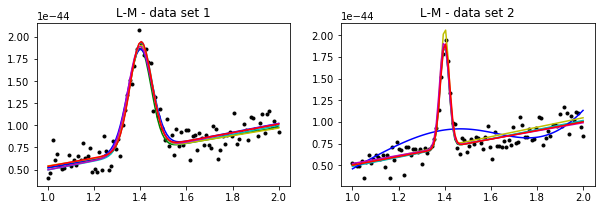

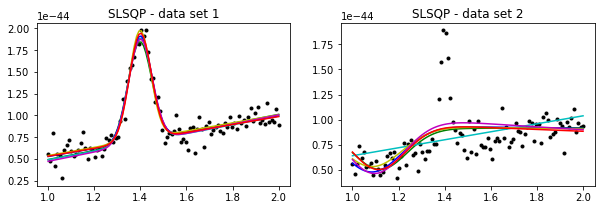

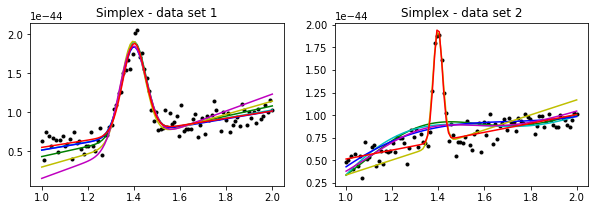

In [4]:
# Scale factor to make flux values look realistic (e.g in flam units)
SCALE = 1e-44

# Build two data sets with simulated Gaussian + linear components. The 
# data sets are identical except for the width of the Gaussian component: 
# data set 2 has a narrower Gaussian. 
#
# This is noiseless data, the test function adds actual noise realizations 
# to these data.
width1 = 0.05
width2 = 0.02
wave = np.linspace(1, 2, 100)
f1 = (1.2 * SCALE * np.exp(-0.5 * (wave - 1.4)**2 / width1**2) +
      SCALE * (0.01 + 0.5 * wave))
f2 = (1.2 * SCALE * np.exp(-0.5 * (wave - 1.4)**2 / width2**2) +
      SCALE * (0.01 + 0.5 * wave))

model = models.Gaussian1D() + models.Linear1D()

fit_and_plot(model, wave, f1, f2, SCALE)

Lets now repeat the fits above, but in specviz's way, using first guesses derived from the data instead of normalization to [-1:1]. 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5925911989292267e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8204589956505473e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5986998269230079e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8635474774348382e-87
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6074643257823605e-87
            Iterations: 1
            

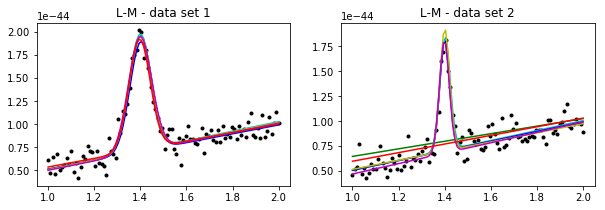

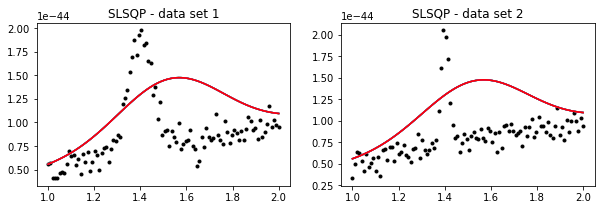

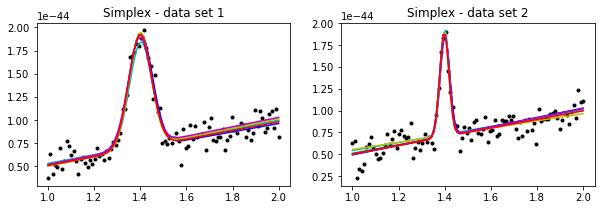

In [5]:
def initialize_gaussian(w, f):
    centroid = np.sum(w * f) / np.sum(f)

    dw = w - np.mean(w)
    fwhm = 2 * np.sqrt(np.sum((dw * dw) * f) / np.sum(f))
    sigma = fwhm / 2.355

    delta_w = w[1:] - w[:-1]
    sum_f = np.sum((f[1:] - np.min(f[1:])) * delta_w)
    height = sum_f / (sigma * np.sqrt( 2 * np.pi))
    
    return height, centroid, sigma

def initialize_linear(w, f):
    # compute averages at the 5% of data at each extreme of the wavelength range.
    l = int(len(w) / 20)
    w1 = np.mean(w[0:l])
    w2 = np.mean(w[-l-1:-1])
    f1 = np.mean(f[0:l])
    f2 = np.mean(f[-l-1:-1])
    # fit a straigth line thru these 
    slope = (f2 - f1) / (w2 - w1)
    inter = f2 - slope * w2
    return slope, inter

h, c, s = initialize_gaussian(wave, f1)
gaussian = models.Gaussian1D(amplitude=h, mean=c, stddev=s)
s, i = initialize_linear(wave, f1)
linear = models.Linear1D(slope=s, intercept=i)
model = gaussian + linear

fit_and_plot(model, wave, f1, f2, SCALE, normalize=False)